# ETB Bank - Loan Approval System 

# 1. Import and Install

In [1]:
#! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [2]:
#!pip install scikit-learn==0.23.1

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [61]:
df0 = pd.read_csv(r'credit0.csv')
df1 = pd.read_csv(r'credit1.csv')
df2 = pd.read_csv(r'credit2.csv', delimiter=";")
df3 = pd.read_csv(r'credit3.csv', delimiter=";")
df_metadata = pd.read_excel(r'Metadata.xlsx')

# 2. Exploratory Data Analysis

## **2.1. Data Understanding**

****
- 950 observations with unique Customer ID.
- 24 independent variables.
- 01 dependent variable: 'Credit' renamed to 'Customer Classification'.
****
- df0 = by customerid, dataset with demographics (ranked).
- df1 = by customerid, dataset with score and loan amount (value).
- df2 = by customerid, dataset with demographics as categorical data. And variable credit (good/bad).
- df3 = by customerid, dataset with demographics (ranked), credit (good/bad), score and loan amount (value).
- df_metadata = all variables explained.
****
- Credit = comes from creditability with outcome good/bad. It will be used as the dependant variable to train the predictive model.
- Score = The score assigned by a sumatory of values explained in the metadata.

In [5]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 25)

In [6]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950 entries, 0 to 949
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   customerid                 950 non-null    int64 
 1   credit                     950 non-null    object
 2   score                      950 non-null    int64 
 3   loan_amount_requested      950 non-null    int64 
 4   current_account            950 non-null    int64 
 5   duration                   950 non-null    int64 
 6   previous_credit            950 non-null    int64 
 7   purpose                    950 non-null    int64 
 8   amount                     950 non-null    int64 
 9   value_saving_stocks        950 non-null    int64 
 10  tenure                     950 non-null    int64 
 11  install_rate               950 non-null    int64 
 12  marital_status_sex         950 non-null    int64 
 13  debtor_guarantors          950 non-null    int64 
 14  living_at_

In [7]:
#from pandas_profiling import ProfileReport
#profile = ProfileReport(df3)
#profile

In [8]:
#profile.to_file("EDA - Bank ETB.html")

## **2.2. Data Preparation**

**Cleaning**

In [62]:
missing_values = df3.isnull().sum().sum() + df2.isnull().sum().sum() + df1.isnull().sum().sum() + df0.isnull().sum().sum()
print(r'Dataframes missing values:', missing_values)
duplicated = df3['customerid'].duplicated().sum() + df2['customerid'].duplicated().sum() + df1['customerid'].duplicated().sum() + df0['customerid'].duplicated().sum()
print(r'Dataframes duplicates:', duplicated)

Dataframes missing values: 20900
Dataframes duplicates: 949


In [63]:
df2.dropna(inplace=True)

In [64]:
missing_values = df3.isnull().sum().sum() + df2.isnull().sum().sum() + df1.isnull().sum().sum() + df0.isnull().sum().sum()
print(r'Dataframes missing values:', missing_values)
duplicated = df3['customerid'].duplicated().sum() + df2['customerid'].duplicated().sum() + df1['customerid'].duplicated().sum() + df0['customerid'].duplicated().sum()
print(r'Dataframes duplicates:', duplicated)

Dataframes missing values: 0
Dataframes duplicates: 0


**Transformation**

Credit will be defined as the dependent variable: as we are going to predict if the customer will be a good prospect (will pay the debt) or not. Past criteria for this decision is not described, and seems to be different to score>60. 
- good = 1
- bad = 0

In [65]:
df3['customerid'] = df3['customerid'].astype('int64')

In [66]:
df3['customer_classification'] = df3['credit']
df3['customer_classification'] = df3['customer_classification'].map({'good': 1, 'bad': 0})
df3['customer_classification'] = df3['customer_classification'].astype(int)
move_cc = df3.pop('customer_classification')
df3.insert(2, 'customer_classification', move_cc)

filt_score = df3['score'] >60
df3['scoring_approved'] = filt_score
move_sc = df3.pop('scoring_approved')
df3.insert(4, 'scoring_approved', move_sc)

In [67]:
cols=df3[['customer_classification', 'score','scoring_approved', 'loan_amount_requested']]
df2 = df2.merge(cols, left_index=True, right_index=True, how='left')

In [68]:
df2.head()

,customerid,credit,current_account,duration,previous_credit,purpose,amount,value_saving_stocks,tenure,install_rate,...,apartment_type,credits_at_bank,occupation,num_dependents,broadband,foreign_worker,customer_classification,score,scoring_approved,loan_amount_requested
1,1001.0,good,no_balance_or_debit,from_06_to_12,no_previous_credit_or_paid_back_all_previous_c...,used_car,from_0.5K_to_1K,from_500_to_1000_DM,less_than_1_year,more_than_35_percent,...,free_apartment,one,unskilled_with_permanent_residence,three_or_more,no,yes,0.0,51.0,False,1980.0
3,1002.0,bad,more_than_200_DM,from_06_to_12,no_previous_credit_or_paid_back_all_previous_c...,used_car,from_1.5K_to_2.5K,not_available_or_no_savings,less_than_1_year,from_20_to_35_percent,...,free_apartment,two_or_three,skilled_worker,three_or_more,no,yes,0.0,55.0,False,674.0
5,1003.0,good,no_balance_or_debit,from_06_to_12,no_problems_current_credit_at_bank,furniture,from_0.5K_to_1K,not_available_or_no_savings,from_1_to_4_years,less_than_20_percent,...,free_apartment,two_or_three,skilled_worker,three_or_more,no,yes,0.0,50.0,False,1282.0
7,1004.0,bad,no_running_account,from_06_to_12,no_previous_credit_or_paid_back_all_previous_c...,furniture,from_0.5K_to_1K,less_than_100_DM,from_4_to_7_years,less_than_20_percent,...,rented_flat,one,skilled_worker,three_or_more,no,yes,1.0,50.0,False,1577.0
9,1005.0,good,no_running_account,from_06_to_12,no_previous_credit_or_paid_back_all_previous_c...,furniture,from_1K_to_1.5K,not_available_or_no_savings,from_1_to_4_years,from_20_to_35_percent,...,free_apartment,one,executive,up_to_two,yes,yes,0.0,45.0,False,2039.0


In [16]:
df2_dummified = pd.get_dummies(df2)

**Outliers**

In [17]:
%matplotlib inline

array([[<AxesSubplot: title={'center': 'score'}>,
        <AxesSubplot: title={'center': 'loan_amount_requested'}>],
       [<AxesSubplot: title={'center': 'purpose'}>,
        <AxesSubplot: title={'center': 'marital_status_sex'}>]],
      dtype=object)

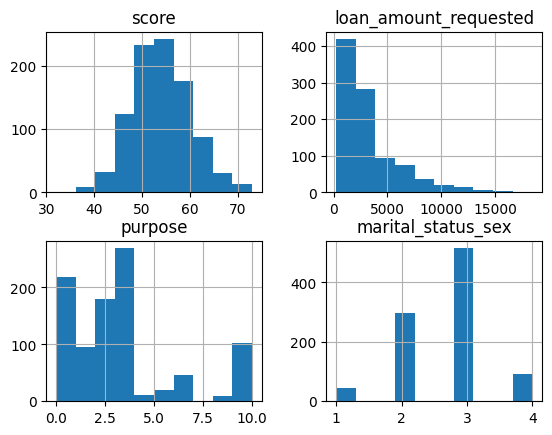

In [18]:
quick_viz = df3[['score', 'loan_amount_requested', 'purpose', 'marital_status_sex']]
quick_viz.hist()

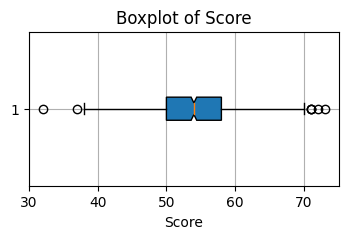

Q0 (0) = 32.0, Q1 (25%) = 50.0, Q3 (75%) = 58.0, Q4 (100%) = 73.0,


In [19]:
Q4 = df3['score'].quantile(1)
Q0 = df3['score'].quantile(0)
seventy_fifth = df3['score'].quantile(0.75)
twenty_fifth = df3['score'].quantile(0.25)
iqr = seventy_fifth - twenty_fifth
upper = seventy_fifth + (1.5 * iqr)
lower = twenty_fifth - (1.5 * iqr)
outliers = df3[(df3['score'] > upper) | (df3['score'] < lower)]
outliers_quantity_1 = outliers.shape[0]


plt.figure(figsize=(4, 2))
plt.boxplot(df3['score'], vert=False, patch_artist=True, notch=True)
plt.title('Boxplot of Score')
plt.xlabel('Score')
plt.grid(True)
plt.show()
print(f'Q0 (0) = {Q0}, Q1 (25%) = {twenty_fifth}, Q3 (75%) = {seventy_fifth}, Q4 (100%) = {Q4},')

- The quantity of outliers in the dataframe for the score assigned to customers: 07 observations. It is not considered necessary to take action upon them as the scaling factor 'k' is considered low; and not significantly deviated from the rest.
- 50% of customers have a score between  50 and 58; and 75% of customers, below 58. 
- Few outliers can be spotted visually, above 70 and below 40.



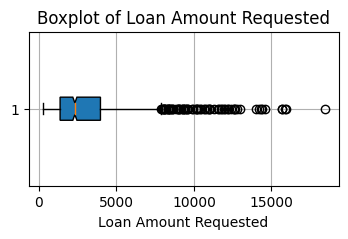

In [20]:
seventy_fifth_2 = df3['loan_amount_requested'].quantile(0.75)
twenty_fifth_2 = df3['loan_amount_requested'].quantile(0.25)
iqr_2 = seventy_fifth_2 - twenty_fifth_2
upper_2 = seventy_fifth_2 + (1.5 * iqr_2)
lower_2 = twenty_fifth_2 -  (1.5 * iqr_2)
outliers_2 = df3[(df3['loan_amount_requested'] < lower_2) | (df3['loan_amount_requested'] > upper_2)]
outliers_quantity_2 = outliers_2.shape[0]

plt.figure(figsize=(4, 2))
plt.boxplot(df3['loan_amount_requested'], vert=False, patch_artist=True, notch=True)
plt.title('Boxplot of Loan Amount Requested')
plt.xlabel('Loan Amount Requested')
plt.grid(True)
plt.show()

- The amount of outliers in the dataframe for the amount requested by customer is 21 observations, all located on the upper values. No imputation or cleanning needed as the frequency decreases as the loan amount requested increase. Might be also explained by a wider range on the upper limit.
- The most prominent outlier is the max value found at 17,500.
- Q2 or median for the loan amount requested is 2,325.

**Correlations**

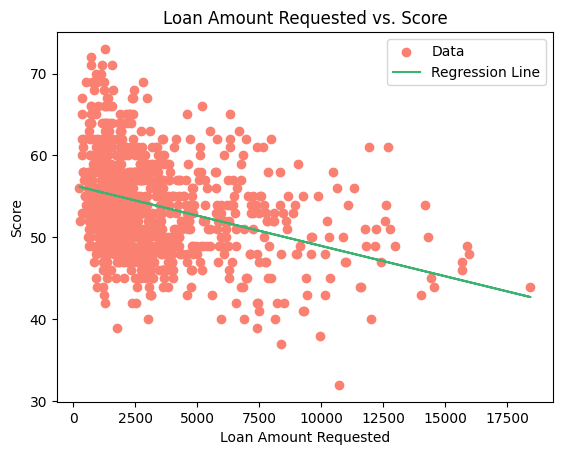

- Hyphotesis: as greater the Score is, the lower the Loan Amount Requested will be -  No Correlation
- Just these two continous variables are available to analyze correlations.


In [21]:
plt.scatter(df3['loan_amount_requested'], df3['score'], color='salmon', label='Data')

coef = np.polyfit(df3['loan_amount_requested'], df3['score'], 1)  
poly1d_fn = np.poly1d(coef) 

plt.plot(df3['loan_amount_requested'], poly1d_fn(df3['loan_amount_requested']), color='mediumseagreen', label='Regression Line')

plt.title('Loan Amount Requested vs. Score')
plt.xlabel('Loan Amount Requested')
plt.ylabel('Score')
plt.legend()
plt.show()
print('- \033[1mHyphotesis:\033[0m as greater the Score is, the lower the Loan Amount Requested will be -  \033[1mNo Correlation\033[0m')
print(r'- Just these two continous variables are available to analyze correlations.')

In [22]:
## 3. Descriptive Analysis 
## EDA =  descriptive statistics and data visualization techniques

## **2.3. Descriptive Analysis**

### **2.3.1. Customer Overview**

**Score**
- ***Min Score:*** 32 points.
- ***Max Score:*** 73 points.
- ***Coefficient of Variation (CV):*** 11%
***
**Loan Amount Requested**
- 75% of customers requested loans below 3,975.
- ***Min value*** = 250.00, ***Max Value*** = 18,424.00,
- ***Q1 (25%)*** = 1,372.50,  ***Q2 (50%)*** = 2,325.50, ***Q3 (75%)*** = 3,975.25
- ***Coefficient of Variation (CV):*** 85%.
- The bank has granted 3,103,287 on loans.
***
**Correlations:**
- The lower the loan duration is, the lower the loan amount requested will be (strong).
- The higher the score is, the lower the loadn amount requested will be (weak).
***
**General**
- ***85%*** of customers are male (***54% male married/widowed*** and 31% male single). 
- ***96%*** are considered ***foreign workers*** - could be an Online Finanancial Service or an International Bank. 
- On an ***age*** range of 0-25 (20%), ***26-39 (53%)*** and 40-59 (26%).
- With ***3 or more dependents: 84%***.
- Being ***64%*** of them with a current ***occupation*** as ***skilled worker / skilled employee / minor civil servant***.
- ***71%*** lives in an  ***rented flat***. 
- The more frequent loan ***duration*** is ***12-24 months***, and the least: 48 months or more.
- Portfolio of clients has in majority ***no previous credits or paid back all previous credits***.
- Purpose: ***28% for furniture,*** 23% other, 19% for a used car. 
- Third part of customers have been ***employed for 1 to 4 years.***
- ***90% requested*** a loan ***without no further debtors or guarantors***.
- ***81% has no further running credits.***



In [23]:
df3.describe()

,customerid,customer_classification,score,loan_amount_requested,current_account,duration,previous_credit,purpose,amount,value_saving_stocks,tenure,install_rate,marital_status_sex,debtor_guarantors,living_at_current_address,valueable_assets,age,other_credits,apartment_type,credits_at_bank,occupation,num_dependents,broadband,foreign_worker
count,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000
mean,1475.500000,0.696842,53.940000,3266.617895,2.576842,7.378947,2.529474,2.817895,6.654737,2.095789,3.370526,2.974737,2.685263,1.146316,2.801053,2.353684,2.064211,2.676842,1.912632,1.397895,2.905263,1.160000,1.400000,1.037895
std,274.385677,0.459865,5.950054,2789.917873,1.258853,1.950272,1.080859,2.724338,1.551624,1.574388,1.186318,1.117630,0.710373,0.480014,1.104354,1.036307,0.683297,0.703589,0.525181,0.569321,0.637330,0.366799,0.490156,0.191042
min,1001.000000,0.000000,32.000000,250.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1238.250000,0.000000,50.000000,1372.500000,1.000000,7.000000,2.000000,1.000000,6.000000,1.000000,3.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,3.000000,2.000000,1.000000,3.000000,1.000000,1.000000,1.000000
50%,1475.500000,1.000000,54.000000,2325.500000,2.000000,8.000000,2.000000,2.000000,7.000000,1.000000,3.000000,3.000000,3.000000,1.000000,3.000000,2.000000,2.000000,3.000000,2.000000,1.000000,3.000000,1.000000,1.000000,1.000000
75%,1712.750000,1.000000,58.000000,3975.250000,4.000000,9.000000,4.000000,3.000000,8.000000,3.000000,4.000000,4.000000,3.000000,1.000000,4.000000,3.000000,3.000000,3.000000,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000
max,1950.000000,1.000000,73.000000,18424.000000,4.000000,10.000000,4.000000,10.000000,10.000000,5.000000,5.000000,4.000000,4.000000,3.000000,4.000000,4.000000,5.000000,3.000000,3.000000,4.000000,4.000000,2.000000,2.000000,2.000000


### 2.3.2. Customer Classification

**Credit / Customer Classification**
- 662 (70%) are classified as credit worthy (good).
- 288 (30%) are classified as not credit worthy (bad).
***
**Good Customers**
- Score between 32 and 73 with a median of 55.
- A total of 1,984,005 was granted to good customers. With a median of 2,264 each.
- Good Customers are skilled foreign workers males, between 26 and 39 years old (and older) who live in a rented flat, with 3 dependants or more.
- Half these customers have more than 200 con the current account.
- Just 5% of good customers have had problematic running account, or hesitant payment of previous credits.
- They require a loan for a used car or furniture.
***
**Bad Customers**
- Score between 38 and 71 with a median of 51.
- A total of 1,119,282 was granted to bad customers. With a median of 2,554 each.
- Bad Customers are skilled foreign workers males, between 26 and 39 years old (and younger) who live in a rented flat, with 3 dependants or more.
- Amost half these customers have no running account.
- 17% of bad customers have had problematic running account, or hesitant payment of previous credits.
- They require a loan for a used car or furniture.

In [69]:
#Good-Describe
credit_group = df3.groupby(['credit'])
credit_group.get_group('good').describe()

,customerid,customer_classification,score,loan_amount_requested,current_account,duration,previous_credit,purpose,amount,value_saving_stocks,...,living_at_current_address,valueable_assets,age,other_credits,apartment_type,credits_at_bank,occupation,num_dependents,broadband,foreign_worker
count,662.000000,662.0,662.000000,662.000000,662.000000,662.000000,662.000000,662.000000,662.000000,662.000000,...,662.000000,662.000000,662.000000,662.000000,662.000000,662.000000,662.000000,662.000000,662.000000,662.000000
mean,1495.445619,1.0,55.070997,2996.986405,2.870091,7.641994,2.685801,2.818731,6.746224,2.283988,...,2.793051,2.259819,2.110272,2.725076,1.916918,1.415408,2.897281,1.161631,1.412387,1.048338
std,269.302712,0.0,5.746493,2390.118664,1.226798,1.809436,1.044144,2.643248,1.449798,1.644967,...,1.107428,1.022671,0.656574,0.657741,0.486474,0.572653,0.625982,0.368391,0.492636,0.214642
min,1001.000000,1.0,32.000000,250.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1265.250000,1.0,51.000000,1388.750000,2.000000,7.000000,2.000000,1.000000,6.000000,1.000000,...,2.000000,1.000000,2.000000,3.000000,2.000000,1.000000,3.000000,1.000000,1.000000,1.000000
50%,1512.500000,1.0,55.000000,2264.000000,3.000000,8.000000,2.000000,2.000000,7.000000,1.000000,...,3.000000,2.000000,2.000000,3.000000,2.000000,1.000000,3.000000,1.000000,1.000000,1.000000
75%,1724.250000,1.0,59.000000,3640.250000,4.000000,9.000000,4.000000,3.000000,8.000000,4.000000,...,4.000000,3.000000,3.000000,3.000000,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000
max,1948.000000,1.0,73.000000,15857.000000,4.000000,10.000000,4.000000,10.000000,10.000000,5.000000,...,4.000000,4.000000,3.000000,3.000000,3.000000,4.000000,4.000000,2.000000,2.000000,2.000000


In [70]:
#Bad-Describe
credit_group = df3.groupby(['credit'])
credit_group.get_group('bad').describe()

,customerid,customer_classification,score,loan_amount_requested,current_account,duration,previous_credit,purpose,amount,value_saving_stocks,...,living_at_current_address,valueable_assets,age,other_credits,apartment_type,credits_at_bank,occupation,num_dependents,broadband,foreign_worker
count,288.000000,288.0,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,...,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000
mean,1429.652778,0.0,51.340278,3886.395833,1.902778,6.774306,2.170139,2.815972,6.444444,1.663194,...,2.819444,2.569444,1.958333,2.565972,1.902778,1.357639,2.923611,1.156250,1.371528,1.013889
std,280.869588,0.0,5.592632,3468.045722,1.058033,2.123643,1.079849,2.906946,1.748181,1.301741,...,1.098956,1.036967,0.731330,0.789183,0.605658,0.560498,0.663429,0.363724,0.484054,0.117234
min,1002.000000,0.0,38.000000,433.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1172.500000,0.0,48.000000,1342.250000,1.000000,5.000000,2.000000,0.000000,5.000000,1.000000,...,2.000000,2.000000,1.000000,3.000000,2.000000,1.000000,3.000000,1.000000,1.000000,1.000000
50%,1394.500000,0.0,51.000000,2554.000000,2.000000,7.000000,2.000000,2.000000,6.000000,1.000000,...,3.000000,3.000000,2.000000,3.000000,2.000000,1.000000,3.000000,1.000000,1.000000,1.000000
75%,1681.500000,0.0,55.000000,5026.250000,2.000000,8.250000,3.000000,3.000000,8.000000,2.000000,...,4.000000,3.000000,2.000000,3.000000,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000
max,1950.000000,0.0,71.000000,18424.000000,4.000000,10.000000,4.000000,10.000000,10.000000,5.000000,...,4.000000,4.000000,5.000000,3.000000,3.000000,4.000000,4.000000,2.000000,2.000000,2.000000


In [71]:
credit_group['loan_amount_requested'].sum().loc['good']

1984005

In [72]:
credit_group['marital_status_sex'].value_counts().loc['good']

marital_status_sex
3    377
2    191
4     67
1     27
Name: marital_status_sex, dtype: int64

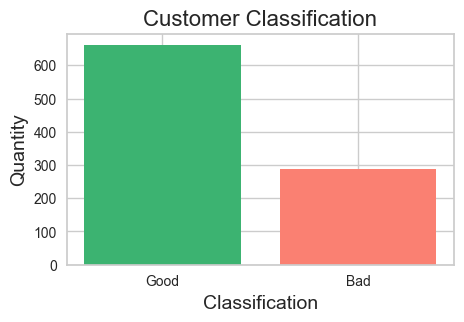

In [73]:
credit_counts = df2['credit'].value_counts().reindex(['good', 'bad'], fill_value=0)

plt.figure(figsize=(5, 3))
plt.bar(credit_counts.index, credit_counts.values, color=['mediumseagreen', 'salmon'])

plt.title('Customer Classification', fontsize=16)
plt.xlabel('Classification', fontsize=14)
plt.ylabel('Quantity', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['Good', 'Bad'])
plt.show()

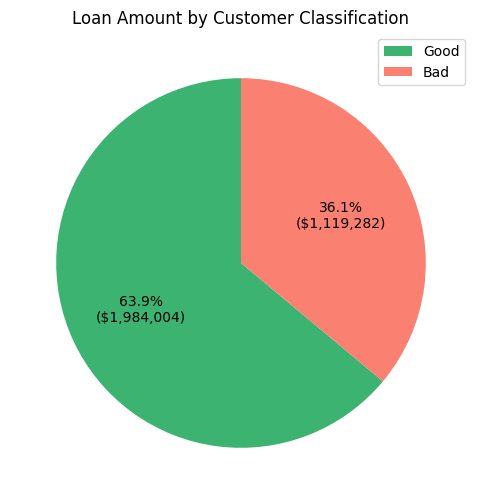

In [29]:
amount_good = credit_group['loan_amount_requested'].sum().loc['good']
amount_bad = credit_group['loan_amount_requested'].sum().loc['bad']

labels = ['Good', 'Bad']
sizes = [amount_good, amount_bad]

autopct = lambda pct: f'{pct:.1f}%\n(${int(pct * sum(sizes) / 100):,})'

plt.figure(figsize=(6, 6))
plt.pie(sizes, autopct=autopct, startangle=90, colors=['mediumseagreen', 'salmon'])
plt.legend(labels + [f'Good: ${amount_good:,}', f'Bad: ${amount_bad:,}'], loc='upper right')
plt.title('Loan Amount by Customer Classification')

plt.show()

### 2.3.3. Classification by Scoring

**Two loan approval methods are under study to determine if a loan can be granted to a customer or not: (1) a score based on customer behavior and demographics, with a set of equally weighted scores (and summed), with an approval threshold=60. (2) And a Predictive Model (to be trained).**

- 164 (17%) are credit worthy to scoring method.
- 786 (83%) are not credit worthy to scoring method.
- Score approval threshold applied at 60 points ore more.
- Score or scoring  will be later used to compare results with the Predictive Model.
- The higher the score, the higher probability to pay debt (hyphotesis). 
- This method does not strongly discriminates customers based on their behavior with previous credits; nor for other variable of interest, such as: loan amount requested, duration, tenure to be considered. This might happen because this is not a weighted average, but a total sum.
- It doesnt seems to consider how attractive is for the bank in terms of interest rate.
- Customer's Scoring has a normal distribution.

***
**Credit worthy according to scoring methodology:**           
- Score between 60 and 73 with a median of 62.
- A total of 363,811 was requested by "credit worthy customers". With a median of 1,516 each.
- These customers are skilled foreign workers, males, between 26 and 58 years old who live in a rented flat, with 3 or more dependants.
- Half these customers have more than 200 con the current account.
- Just 3% of these customers have had problematic running account, or hesitant payment of previous credits.
- They require a loan for furniture, retraining or a repair.
- Almost all customers have between 1-3 credits (considering the running one).
***
**Not Credit worthy according to scoring methodology:**    
- Score between 32 and 59 with a median of 52.
- A total of 2,739,476 was requested by "not credit worthy customers". With a median of 2,576 each.
- These customers are skilled foreign workers, males, between 26 and 38 years old (and younger) who live in a rented flat, with 3 or more dependants.
- They have more than 200 on their current account or have no running account.
- 10% of these customers have had problematic running account, or hesitant payment of previous credits.
- They require a loan for furniture or a used car.
- Almost all customers have between 1-3 credits (considering the running one).

In [74]:
filt_yes = df3['score'] >= 60
score_cr_worthy = df3.groupby(filt_yes)
score_cr_worthy.get_group(True).describe()

,customerid,customer_classification,score,loan_amount_requested,current_account,duration,previous_credit,purpose,amount,value_saving_stocks,...,living_at_current_address,valueable_assets,age,other_credits,apartment_type,credits_at_bank,occupation,num_dependents,broadband,foreign_worker
count,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,...,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.00000
mean,1623.000000,0.865854,63.048780,2218.359756,3.268293,8.103659,3.134146,4.963415,7.371951,3.121951,...,3.262195,2.500000,2.420732,2.731707,2.030488,1.695122,2.981707,1.219512,1.567073,1.02439
std,241.583732,0.341853,3.014901,1971.798758,1.074510,1.336688,1.006265,3.212113,1.401820,1.764616,...,0.932460,1.018239,0.575414,0.646819,0.475456,0.677220,0.591064,0.415184,0.496998,0.15473
min,1015.000000,0.000000,60.000000,338.000000,1.000000,3.000000,0.000000,0.000000,3.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000
25%,1479.750000,1.000000,61.000000,1145.750000,2.000000,7.000000,2.000000,3.000000,7.000000,1.000000,...,2.000000,2.000000,2.000000,3.000000,2.000000,1.000000,3.000000,1.000000,1.000000,1.00000
50%,1679.000000,1.000000,62.000000,1516.500000,4.000000,8.000000,4.000000,3.000000,7.000000,3.000000,...,4.000000,3.000000,2.000000,3.000000,2.000000,2.000000,3.000000,1.000000,2.000000,1.00000
75%,1823.250000,1.000000,65.000000,2430.750000,4.000000,9.000000,4.000000,9.000000,8.000000,5.000000,...,4.000000,3.000000,3.000000,3.000000,2.000000,2.000000,3.000000,1.000000,2.000000,1.00000
max,1944.000000,1.000000,73.000000,12680.000000,4.000000,10.000000,4.000000,10.000000,10.000000,5.000000,...,4.000000,4.000000,3.000000,3.000000,3.000000,4.000000,4.000000,2.000000,2.000000,2.00000


In [75]:
score_cr_worthy.get_group(False).describe()

,customerid,customer_classification,score,loan_amount_requested,current_account,duration,previous_credit,purpose,amount,value_saving_stocks,...,living_at_current_address,valueable_assets,age,other_credits,apartment_type,credits_at_bank,occupation,num_dependents,broadband,foreign_worker
count,786.000000,786.000000,786.000000,786.000000,786.000000,786.000000,786.000000,786.000000,786.000000,786.000000,...,786.000000,786.000000,786.000000,786.000000,786.000000,786.000000,786.000000,786.000000,786.000000,786.000000
mean,1444.723919,0.661578,52.039440,3485.338422,2.432570,7.227735,2.403308,2.370229,6.505089,1.881679,...,2.704835,2.323155,1.989822,2.665394,1.888041,1.335878,2.889313,1.147583,1.365140,1.040712
std,270.931912,0.473474,4.467829,2885.306901,1.247125,2.023504,1.053445,2.380725,1.540320,1.443631,...,1.113622,1.038077,0.680875,0.714721,0.531969,0.523740,0.645780,0.354912,0.481776,0.197749
min,1001.000000,0.000000,32.000000,250.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1207.250000,0.000000,49.000000,1470.000000,1.000000,6.000000,2.000000,0.000000,6.000000,1.000000,...,2.000000,1.000000,2.000000,3.000000,2.000000,1.000000,3.000000,1.000000,1.000000,1.000000
50%,1430.500000,1.000000,52.000000,2576.500000,2.000000,8.000000,2.000000,2.000000,6.000000,1.000000,...,3.000000,2.000000,2.000000,3.000000,2.000000,1.000000,3.000000,1.000000,1.000000,1.000000
75%,1670.750000,1.000000,55.750000,4280.750000,4.000000,9.000000,3.000000,3.000000,8.000000,2.000000,...,4.000000,3.000000,2.000000,3.000000,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000
max,1950.000000,1.000000,59.000000,18424.000000,4.000000,10.000000,4.000000,10.000000,10.000000,5.000000,...,4.000000,4.000000,5.000000,3.000000,3.000000,4.000000,4.000000,2.000000,2.000000,2.000000


In [76]:
score_cr_worthy['credits_at_bank'].get_group(True).value_counts()

2    83
1    67
3    11
4     3
Name: credits_at_bank, dtype: int64

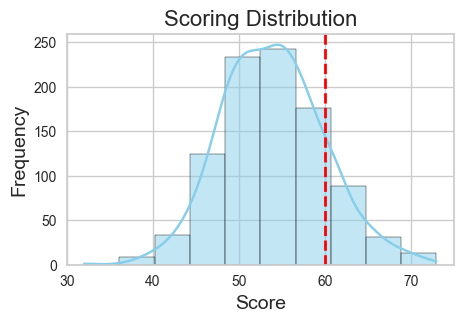

In [77]:
dfscore = pd.DataFrame(df1['score'])

plt.figure(figsize=(5, 3))
sns.histplot(dfscore['score'], bins=10, kde=True, color='skyblue', edgecolor='black')
plt.axvline(x=60, color='red', linestyle='--', linewidth=2)

plt.title('Scoring Distribution', fontsize=16)
plt.xlabel('Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()


## 3. Predictive Model

**3.1. Model Testing**

In [34]:
# modelo 1: dependiente customer classification
# modelo 2: dependiente score>60
# modelo 3: creado a partir de variables de interés

#comparo con accuracy, sensitivity y precisión. Tambien con calculo monetario como en el caso.

In [195]:
cols= df3[['current_account', 'duration', 'previous_credit', 'purpose', 'amount',
                        'value_saving_stocks', 'tenure', 'install_rate', 'marital_status_sex', 'debtor_guarantors',
                        'living_at_current_address', 'valueable_assets', 'age', 'other_credits', 'apartment_type',
                        'credits_at_bank', 'occupation', 'num_dependents', 'broadband', 'foreign_worker']]
m = cols.nunique().sum()
q = df3.shape[1]
obs = df3.shape[0]
max = (6*m*q)
max_features_vs_observations =  obs >= (6*m*q)
print('the rule for amount of observations should be more than the quantity of variables and categories by 6 is fulfilled?')
print(max_features_vs_observations)

the rule for amount of observations should be more than the quantity of variables and categories by 6 is fulfilled?
False


3.1.1. Pycaret Library

In [123]:
from pycaret.classification import *
setup = setup(data=df3,
              target="credit",
              train_size = 0.8,
              numeric_features=['score', 'loan_amount_requested'],
              categorical_features=['current_account', 'duration', 'previous_credit', 'purpose', 'amount',
                        'value_saving_stocks', 'tenure', 'install_rate', 'marital_status_sex', 'debtor_guarantors',
                        'living_at_current_address', 'valueable_assets', 'age', 'other_credits', 'apartment_type',
                        'credits_at_bank', 'occupation', 'num_dependents', 'broadband', 'foreign_worker'],
              ignore_features=["customerid"],
             fold=10)

,Description,Value
0,Session id,7769
1,Target,credit
2,Target type,Binary
3,Target mapping,"bad: 0, good: 1"
4,Original data shape,"(950, 26)"
5,Transformed data shape,"(950, 93)"
6,Transformed train set shape,"(760, 93)"
7,Transformed test set shape,"(190, 93)"
8,Ignore features,1
9,Numeric features,2


In [101]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [102]:
best = compare_models(sort='Accuracy')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0530
nb,Naive Bayes,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0230
dt,Decision Tree Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0220
ridge,Ridge Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0260
rf,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0820
ada,Ada Boost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0210
gbc,Gradient Boosting Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0460
et,Extra Trees Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0680
lightgbm,Light Gradient Boosting Machine,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0420
lda,Linear Discriminant Analysis,0.7684,0.7831,0.7684,0.7619,0.7595,0.4183,0.4269,0.0220


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

In [130]:
model = create_model("lr")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [131]:
print(model.get_params())

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 7769, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [133]:
evaluate_model(model)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [141]:
help(compare_models)

Help on function compare_models in module pycaret.classification.functional:

compare_models(include: Optional[List[Union[str, Any]]] = None, exclude: Optional[List[str]] = None, fold: Union[int, Any, NoneType] = None, round: int = 4, cross_validation: bool = True, sort: str = 'Accuracy', n_select: int = 1, budget_time: Optional[float] = None, turbo: bool = True, errors: str = 'ignore', fit_kwargs: Optional[dict] = None, groups: Union[str, Any, NoneType] = None, experiment_custom_tags: Optional[Dict[str, Any]] = None, probability_threshold: Optional[float] = None, engine: Optional[Dict[str, str]] = None, verbose: bool = True, parallel: Optional[pycaret.internal.parallel.parallel_backend.ParallelBackend] = None) -> Union[Any, List[Any]]
    This function trains and evaluates performance of all estimators available in the
    model library using cross validation. The output of this function is a score grid
    with average cross validated scores. Metrics evaluated during CV can be access

In [ ]:
# KNN Model
#Handled as ordinal variables

In [107]:
X = df3[['score', 'loan_amount_requested', 'current_account', 'duration', 'previous_credit', 'purpose', 'amount',
                        'value_saving_stocks', 'tenure', 'install_rate', 'marital_status_sex', 'debtor_guarantors',
                        'living_at_current_address', 'valueable_assets', 'age', 'other_credits', 'apartment_type',
                        'credits_at_bank', 'occupation', 'num_dependents', 'broadband', 'foreign_worker']].values
y = df3['customer_classification'].values

In [ ]:
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

In [ ]:
k = 1
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

In [ ]:
yhat = neigh.predict(X_test)

In [ ]:
print('ytrain', y_train[:10])
print('ypredc', neigh.predict(X_train)[:10])

In [ ]:
predictions_df = pd.DataFrame({'Original_Train': y_train, 'Predicted_Train': neigh.predict(X_train)})
predictions_df.value_counts()
#overfitted = predictions_df['Original'] == predictions_df['Predicted']
#overfitted.value_counts()

In [ ]:
predictions_df = pd.DataFrame({'Original': y_test, 'Predicted': yhat})
predictions_df.value_counts()

In [ ]:
# jaccard_score
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

## 3. Hypothesis

#### Null Hypothesis: 

#### Experimental Hypothesis:

## 4. Install

#### - Data cleaning and transformation -